In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

In [2]:
df = pd.read_csv("aqi.csv")
df=df.fillna(0)
dataset = df[["SO2"]].values.astype('float32')
dataset

array([[10.76],
       [15.24],
       [26.96],
       ...,
       [ 5.12],
       [ 5.88],
       [ 2.8 ]], dtype=float32)

In [3]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[:train_size], dataset[train_size:]

In [4]:
def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [5]:
lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

/var/folders/d1/rh2g9yxd7g3cyb4mfg9369j80000gr/T/ipykernel_1447/496344701.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(X), torch.tensor(y)


In [6]:
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [7]:
model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

In [8]:
n_epochs = 10
for epoch in range(n_epochs):
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % 100 != 0:
        continue
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))
with torch.no_grad():

    train_plot = np.ones_like(dataset) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]

    test_plot = np.ones_like(dataset) * np.nan
    test_plot[train_size+lookback:len(dataset)] = model(X_test)[:, -1, :]

Epoch 0: train RMSE 6.7109, test RMSE 5.9126


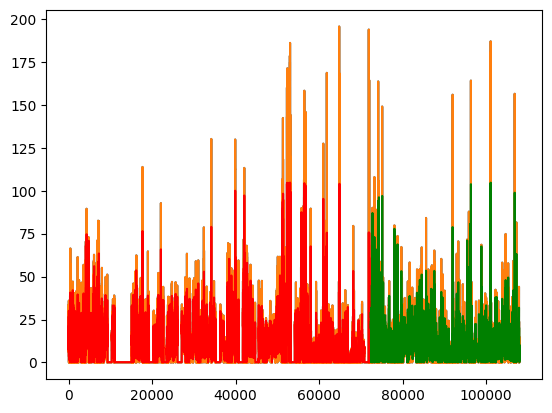

In [ ]:
plt.plot(dataset)
plt.plot(dataset)
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()